# Importing Libraries

In [2]:
#Libraries
import string
import pandas as pd
import re
import numpy as np
import time

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from sklearn.metrics import accuracy_score, classification_report

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from textblob import TextBlob

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adityasaikolluru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adityasaikolluru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adityasaikolluru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/adityasaikolluru/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Importing Dataset

In [5]:
#loading the dataset
hatespeech_dataset = pd.read_csv('labeled_data.csv')
hatespeech_dataset.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
# Understanding the given data
hatespeech_dataset.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


1    19190
2     4163
0     1430
Name: class, dtype: int64

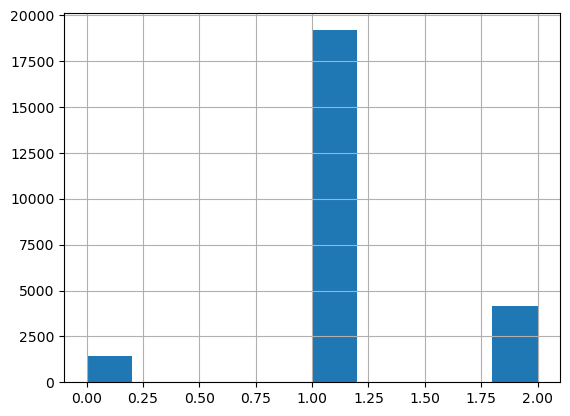

In [7]:
# Understanding the given data and plotting
hatespeech_dataset['class'].hist()
hatespeech_dataset['class'].value_counts()

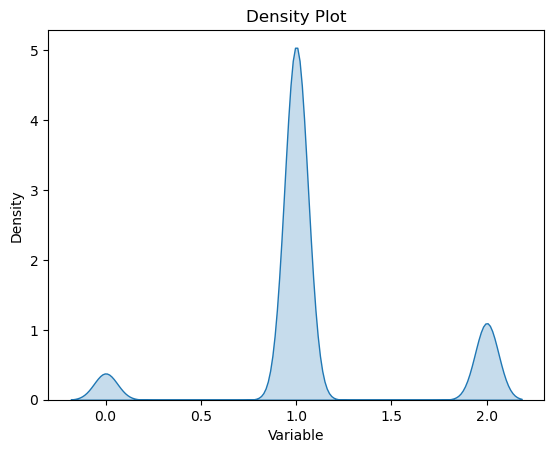

In [8]:
# Understanding the given data and plotting
sns.kdeplot(hatespeech_dataset['class'], shade=True)
plt.xlabel('Variable')
plt.ylabel('Density')
plt.title('Density Plot')
plt.show()

# Data Preprocessing

In [9]:
hatespeech_dataset.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [10]:
hatespeech_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [11]:
#Removing Punctuations
signs = list('''()-[]{}:;'"\,<>./?@#$%^&*_~''')

for sign in signs:   
    hatespeech_dataset['tweet'] = hatespeech_dataset['tweet'].str.replace(sign, '', regex=True)
hatespeech_dataset['tweet'] = hatespeech_dataset['tweet'].apply(lambda x: re.sub(r'[^\w\s]','',x))

In [12]:
# Tokenize the 'tweet' column
hatespeech_dataset['tweet'] = hatespeech_dataset['tweet'].apply(lambda x: nltk.word_tokenize(x))

In [13]:
# Remove numbers from the 'tweet' column
hatespeech_dataset['tweet'] = hatespeech_dataset['tweet'].apply(lambda x: [re.sub(r'\d+', '', word) for word in x])

In [14]:
# Load the stop words
stop_words = nltk.corpus.stopwords.words('english')
other_exclusions = ["#ff", "ff", "rt"]
stop_words.extend(other_exclusions)

# Remove stop words from the 'tokens' column
hatespeech_dataset['tweet'] = hatespeech_dataset['tweet'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [15]:
# Load the PorterStemmer
stemmer = nltk.stem.PorterStemmer()

# Define a function to perform stemming on a list of words
def stem_words(words):
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

# Apply stemming to the 'tokens' column
hatespeech_dataset['tweet'] = hatespeech_dataset['tweet'].apply(stem_words)

In [16]:
# Load the WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a function to perform lemmatization on a list of words
def lemmatize_words(words):
    lemmatized_words = []
    for word in words:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

# Apply lemmatization to the 'tokens' column
hatespeech_dataset['tweet'] = hatespeech_dataset['tweet'].apply(lemmatize_words)

In [17]:
# Convert the tokenized_tweet column to strings
hatespeech_dataset['tweet'] = hatespeech_dataset['tweet'].apply(lambda x: ' '.join(x))

In [18]:
hatespeech_dataset.head(5)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,mayasolov woman shouldnt complain clean hous a...
1,1,3,0,3,0,1,mleew boy dat coldtyga dwn bad cuffin dat hoe ...
2,2,3,0,3,0,1,urkindofbrand dawg sbabylif ever fuck bitch st...
3,3,3,0,2,1,1,cganderson vivabas look like tranni
4,4,6,0,6,0,1,shenikarobert shit hear might true might faker...


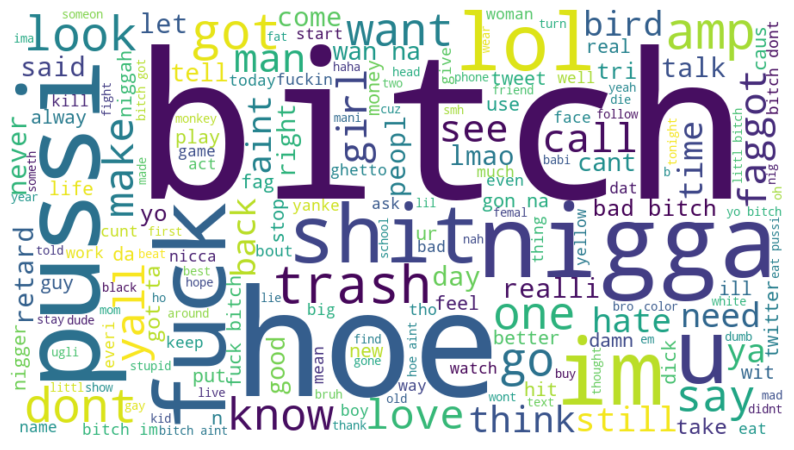

In [19]:
# Join all the tweets together into a single string
all_tweets = ' '.join(hatespeech_dataset['tweet'])

#visualizing which of the word is most commonly used in the twitter dataset
# Generate a word cloud
wordcloud = WordCloud(width = 900, height = 500, 
                background_color ='white',  
                min_font_size = 10).generate(all_tweets)

# Display the word cloud

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Feature generation

In [20]:
X = hatespeech_dataset['tweet']
y = hatespeech_dataset['class']

# Vectorize and normalize the training data\
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X)
scaler = StandardScaler(with_mean=False)
train_vectors_norm = scaler.fit_transform(train_vectors)

# Spliting the data into 80 and 20
X_train,X_test,y_train,y_test= train_test_split(train_vectors_norm,y, train_size=0.80,random_state=1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(19826, 31645) (19826,) (4957, 31645) (4957,)


# Gradient Boosting Classifier

In [21]:
from sklearn.metrics import confusion_matrix
# Train the model
gbm = GradientBoostingClassifier()
start_time = time.time()
gbm.fit(X_train, y_train)

# Make predictions on test set and calculate accuracy
y_preds = gbm.predict(X_test)
gbm_accuracy = accuracy_score(y_test, y_preds)
end_time = time.time()

print("Accuracy:", gbm_accuracy)
print(classification_report(y_test, y_preds))
print("Time taken:", (end_time - start_time)/60,"minutes")
# generate confusion matrix
confusion = confusion_matrix(y_test, y_preds)
print('Confusion matrix:\n', confusion)

Accuracy: 0.8910631430300585
              precision    recall  f1-score   support

           0       0.49      0.20      0.29       296
           1       0.94      0.93      0.94      3853
           2       0.75      0.94      0.84       808

    accuracy                           0.89      4957
   macro avg       0.73      0.69      0.69      4957
weighted avg       0.88      0.89      0.88      4957

Time taken: 1.692132031917572 minutes
Confusion matrix:
 [[  60  181   55]
 [  60 3598  195]
 [   2   47  759]]


# Random Forest Classifier

In [22]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
model.fit(X_train, y_train)

# make predictions on the testing set
test_predictions = model.predict(X_test)

# calculate accuracy and generate classification report
RandomForrest_test_accuracy = accuracy_score(y_test, test_predictions)
end_time = time.time()
#print(classification_report(y_test, test_predictions))
print('Testing accuracy:', RandomForrest_test_accuracy)
print(classification_report(y_test, test_predictions))
print("Time taken:", (end_time - start_time)/60,"minutes")
# generate confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, test_predictions)
print('Confusion matrix:\n', confusion)

Testing accuracy: 0.898325600161388
              precision    recall  f1-score   support

           0       0.61      0.14      0.23       296
           1       0.91      0.97      0.94      3853
           2       0.84      0.84      0.84       808

    accuracy                           0.90      4957
   macro avg       0.79      0.65      0.67      4957
weighted avg       0.88      0.90      0.88      4957

Time taken: 0.7467716018358866 minutes
Confusion matrix:
 [[  41  226   29]
 [  26 3730   97]
 [   0  126  682]]


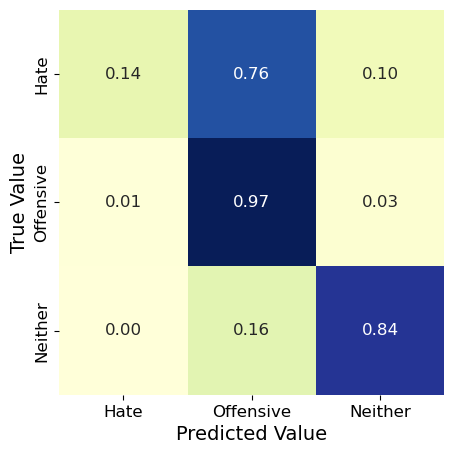

In [23]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,test_predictions)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True Value',fontsize=14)
plt.xlabel(r'Predicted Value',fontsize=14)
plt.tick_params(labelsize=12)


# Logistic Regression using Sentiment Analysis

In [24]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(hatespeech_dataset['tweet'])
tfidf

<24783x7155 sparse matrix of type '<class 'numpy.float64'>'
	with 204428 stored elements in Compressed Sparse Row format>

In [25]:
# collecting only the tweets from the csv file into a variable name tweet
tweet=hatespeech_dataset.tweet

In [26]:
## Sentiment Analysis
sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(tweet)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
new_features

,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.169,0.158,0.673,-0.0382,0.0,0.0,0.0
1,0.259,0.000,0.741,-0.5423,0.0,0.0,0.0
2,0.609,0.000,0.391,-0.8979,0.0,0.0,0.0
3,0.000,0.385,0.615,0.3612,0.0,0.0,0.0
4,0.430,0.163,0.407,-0.6808,0.0,0.0,0.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,0.0,0.0
24779,0.366,0.261,0.373,-0.1779,0.0,0.0,0.0
24780,0.000,0.200,0.800,0.3612,0.0,0.0,0.0
24781,0.432,0.000,0.568,-0.5859,0.0,0.0,0.0


In [27]:
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 7162)

In [28]:
# Running the model Using TFIDF with some features from Logistic Regression using sentiment analysis

X = pd.DataFrame(modelling_features)
y = hatespeech_dataset['class'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
start_time = time.time()
model = LogisticRegression(max_iter=1000).fit(X_train_bow, y_train)
y_preds = model.predict(X_test_bow)
report = classification_report( y_test, y_preds )
LG_SentimentAnalysis_testaccuracy = accuracy_score(y_test,y_preds)
#print(report)
end_time = time.time()
print("Accuracy Score:" , LG_SentimentAnalysis_testaccuracy)
print(classification_report(y_test, y_preds))
print("Time taken:", (end_time - start_time)/60,"minutes")

Accuracy Score: 0.8935054457442517
              precision    recall  f1-score   support

           0       0.62      0.15      0.25       164
           1       0.91      0.97      0.94      1905
           2       0.86      0.84      0.85       410

    accuracy                           0.89      2479
   macro avg       0.80      0.65      0.68      2479
weighted avg       0.88      0.89      0.88      2479

Time taken: 0.5561289668083191 minutes


In [31]:
from tabulate import tabulate
data = [['Random Forrest', RandomForrest_test_accuracy*100],
['Gradient Boosting Classifier', gbm_accuracy*100],
['Logistic Regression with Sentiment Analysis', LG_SentimentAnalysis_testaccuracy*100]]

df_accuracy = pd.DataFrame(data, columns=['Classifier Type', 'Accuracy(%)'])
df_accuracy = df_accuracy.sort_values('Accuracy(%)', ascending=False)

print (tabulate(data, headers=["Classifier Type", "Accuracy(%)"],tablefmt='fancy_grid',floatfmt=".2f"))

╒═════════════════════════════════════════════╤═══════════════╕
│ Classifier Type                             │   Accuracy(%) │
╞═════════════════════════════════════════════╪═══════════════╡
│ Random Forrest                              │         89.83 │
├─────────────────────────────────────────────┼───────────────┤
│ Gradient Boosting Classifier                │         89.11 │
├─────────────────────────────────────────────┼───────────────┤
│ Logistic Regression with Sentiment Analysis │         89.35 │
╘═════════════════════════════════════════════╧═══════════════╛


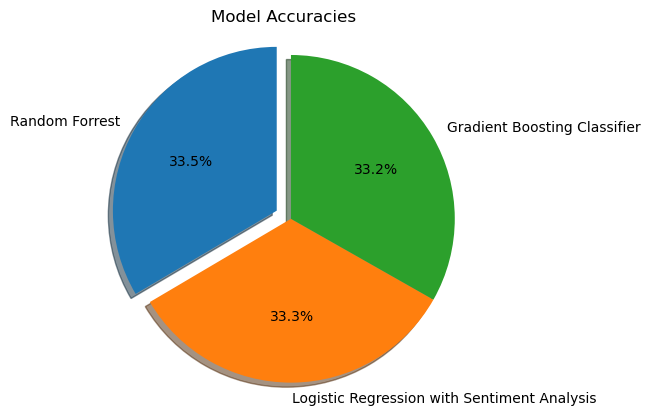

Best Model: Random Forrest
Accuracy of Random Forrest : 0.898325600161388


In [32]:
import matplotlib.pyplot as plt

# Store the accuracies in a dictionary
model_accuracies = {'Random Forrest':RandomForrest_test_accuracy ,'Logistic Regression with Sentiment Analysis': LG_SentimentAnalysis_testaccuracy,'Gradient Boosting Classifier':gbm_accuracy}

# Find the highest accuracy and its corresponding model
best_model = max(model_accuracies, key=model_accuracies.get)

# Set the explode value for the Random Forest slice to highlight it
explode = [0.1 if model == best_model else 0 for model in model_accuracies.keys()]

# Plot the pie chart with the highlighted slice
fig1, ax1 = plt.subplots()
ax1.pie(model_accuracies.values(), explode=explode, labels=model_accuracies.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Model Accuracies')
plt.show()

# Print the results
print('Best Model:', best_model)
print('Accuracy of', best_model, ':', model_accuracies[best_model])
